In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score


In [2]:
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')

cuda:1
torch version : 1.12.1


In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':100,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
df = pd.read_csv('./Dataset/train.csv')
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [6]:
from collections import OrderedDict
classes = {}
for i in df['artist']:
    if i not in classes:
        # count 데이터 수
        classes[i] = 0
    else:
        classes[i] +=1
convert_labels = sorted(classes.items(), key=lambda x : x[1], reverse=True)
print(convert_labels)

for i in range(len(convert_labels)):
    classes[convert_labels[i][0]]=[i,convert_labels[i][1]]
print(classes)

[('Vincent van Gogh', 628), ('Edgar Degas', 488), ('Pablo Picasso', 302), ('Pierre-Auguste Renoir', 232), ('Albrecht Du rer', 219), ('Paul Gauguin', 219), ('Francisco Goya', 203), ('Rembrandt', 180), ('Titian', 172), ('Marc Chagall', 172), ('Alfred Sisley', 164), ('Paul Klee', 141), ('Rene Magritte', 136), ('Andy Warhol', 131), ('Amedeo Modigliani', 131), ('Henri Matisse', 120), ('Sandro Botticelli', 119), ('Mikhail Vrubel', 117), ('Hieronymus Bosch', 114), ('Leonardo da Vinci', 100), ('Salvador Dali', 98), ('Peter Paul Rubens', 96), ('Kazimir Malevich', 90), ('Pieter Bruegel', 84), ('Frida Kahlo', 83), ('Diego Velazquez', 80), ('Joan Miro', 75), ('Andrei Rublev', 73), ('Raphael', 72), ('Giotto di Bondone', 71), ('Gustav Klimt', 68), ('El Greco', 64), ('Jan van Eyck', 63), ('Camille Pissarro', 63), ('Edouard Manet', 61), ('Henri de Toulouse-Lautrec', 60), ('Vasiliy Kandinskiy', 59), ('Claude Monet', 58), ('Piet Mondrian', 58), ('Henri Rousseau', 51), ('Diego Rivera', 49), ('William Tur

In [7]:
new_df = pd.read_csv('./Dataset/artists_info.csv')
print(len(new_df))
new_df.head()

50


,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


In [8]:
# classes [label, count, years, genre, nationality]
for name in classes.keys():
    for i in range(len(new_df)):
        if new_df.loc[i]['name'] == name:
            classes[name].extend(new_df.loc[i].iloc[1:])
            classes[name] = classes[name]
classes = OrderedDict(sorted(classes.items(), key = lambda t : t[1][1],reverse=True))
for i in range(50):
    print(list(classes.keys())[i])
    print(classes[list(classes.keys())[i]])
    

Vincent van Gogh
[0, 628, '1853 – 1890', 'Post-Impressionism', 'Dutch']
Edgar Degas
[1, 488, '1834 - 1917', 'Impressionism', 'French']
Pablo Picasso
[2, 302, '1881 - 1973', 'Cubism', 'Spanish']
Pierre-Auguste Renoir
[3, 232, '1841 - 1919', 'Impressionism', 'French']
Albrecht Du rer
[4, 219, '1471 - 1528', 'Northern Renaissance', 'German']
Paul Gauguin
[5, 219, '1848 – 1903', 'Symbolism,Post-Impressionism', 'French']
Francisco Goya
[6, 203, '1746 - 1828', 'Romanticism', 'Spanish']
Rembrandt
[7, 180, '1606 - 1669', 'Baroque', 'Dutch']
Titian
[8, 172, '1488 - 1576', 'High Renaissance,Mannerism', 'Italian']
Marc Chagall
[9, 172, '1887 - 1985', 'Primitivism', 'French,Jewish,Belarusian']
Alfred Sisley
[10, 164, '1839 - 1899', 'Impressionism', 'French,British']
Paul Klee
[11, 141, '1879 – 1940', 'Expressionism,Abstractionism,Surrealism', 'German,Swiss']
Rene Magritte
[12, 136, '1898 - 1967', 'Surrealism,Impressionism', 'Belgian']
Andy Warhol
[13, 131, '1928 – 1987', 'Pop Art', 'American']
Ame

In [9]:
def cut_data(df,number,class_info,seed):
    print(f'total data : {len(df)}')
    for i in class_info:
        if class_info[i][1] > number:
            a = df[df['artist']==i]
            drop_index = list(a.sample(class_info[i][1]-number,random_state=seed)['id'])
            class_info[i][1]=number
            print(f'{i} delete {len(drop_index)}')
            df.drop(index=drop_index,inplace=True,axis=0)
    print(f'ater data : {len(df)}')
    return df 

In [10]:
df = cut_data(df,100,classes,41)
print(classes)

total data : 5911
Vincent van Gogh delete 528
Edgar Degas delete 388
Pablo Picasso delete 202
Pierre-Auguste Renoir delete 132
Albrecht Du rer delete 119
Paul Gauguin delete 119
Francisco Goya delete 103
Rembrandt delete 80
Titian delete 72
Marc Chagall delete 72
Alfred Sisley delete 64
Paul Klee delete 41
Rene Magritte delete 36
Andy Warhol delete 31
Amedeo Modigliani delete 31
Henri Matisse delete 20
Sandro Botticelli delete 19
Mikhail Vrubel delete 17
Hieronymus Bosch delete 14
ater data : 3823
OrderedDict([('Vincent van Gogh', [0, 100, '1853 – 1890', 'Post-Impressionism', 'Dutch']), ('Edgar Degas', [1, 100, '1834 - 1917', 'Impressionism', 'French']), ('Pablo Picasso', [2, 100, '1881 - 1973', 'Cubism', 'Spanish']), ('Pierre-Auguste Renoir', [3, 100, '1841 - 1919', 'Impressionism', 'French']), ('Albrecht Du rer', [4, 100, '1471 - 1528', 'Northern Renaissance', 'German']), ('Paul Gauguin', [5, 100, '1848 – 1903', 'Symbolism,Post-Impressionism', 'French']), ('Francisco Goya', [6, 100, 

In [11]:
train_df,val_df,_, _ = train_test_split(df, df['artist'].values, test_size=0.2, shuffle=True,random_state=CFG['SEED'])

In [12]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['artist'].values

In [13]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [14]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, class_info,transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms
        self.classes = class_info
    
    def __getitem__(self, index):
        img_path = './Dataset'+self.img_paths[index][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.labels is not None:
            label = torch.zeros([50], dtype=torch.float32)
            label[self.classes[self.labels[index]][0]] = 1
            # print(f'artist name {self.labels[index]} , label = {self.classes[self.labels[index]][0]}')
            return image, label
        else:
            return image
    def __len__(self):
        return len(self.img_paths)      
    
    def getclasses(self):
        return self.classes

In [15]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224,224),
    A.HorizontalFlip( p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, p=0.5),
    # A.CoarseDropout(max_holes=4, max_height=16, max_width=16, 
    #                          min_holes=None, min_height=16, min_width=16,always_apply=False, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229,0.224,0.224), max_pixel_value=255),
    #A.Normalize(max_pixel_value=255),
    # (HxWxC) -> (CxHxW)
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    #A.Normalize(max_pixel_value=255),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229,0.224,0.224), max_pixel_value=255),
    ToTensorV2()
])

In [16]:
train_dataset = CustomDataset(train_img_paths, train_labels,classes, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val_img_paths,val_labels,classes, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

torch.Size([16, 3, 224, 224]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(2.5292) tensor(-2.1179)


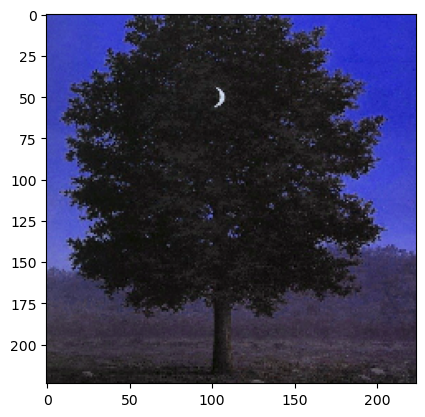

In [17]:
import matplotlib.pyplot as plt
img_mean=(0.485, 0.456, 0.406)
img_std= (0.229,0.224,0.224)
t,l = next(iter(train_loader))
print(t.shape,l[0])
print(torch.max(t[0]), torch.min(t[0]))
t[0]= t[0] * torch.tensor(img_std).view(3, 1, 1) + torch.tensor(img_mean).view(3, 1, 1)
plt.imshow(t[0].detach().cpu().numpy().transpose(1,2,0))

In [18]:
from torchvision.models import convnext_large,ConvNeXt_Large_Weights
from torchvision import models

import timm
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(classes)):
        super(BaseModel, self).__init__()
        #self.backbone = convnext_large(weight=ConvNeXt_Large_Weights.DEFAULT)
        # self.backbone = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)
        self.backbone = timm.models.regnetx_064(pretrained=True,num_classes=50)
        #self.backbone = timm.create_model('coatnet_3_224',pretrained=True)
        #self.backbone = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
        #self.backbone= models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        #self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        self.drop = nn.Dropout(0.5,inplace=True)
    def forward(self, x):
        x = self.backbone(x)
        # x = self.drop(x)
        # x = self.classifier(x)
        return x

In [19]:
import torchsummary
model = BaseModel()
torchsummary.summary(model, (3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              ReLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
       ConvNormAct-5         [-1, 32, 112, 112]               0
            Conv2d-6        [-1, 168, 112, 112]           5,376
          Identity-7        [-1, 168, 112, 112]               0
              ReLU-8        [-1, 168, 112, 112]               0
    BatchNormAct2d-9        [-1, 168, 112, 112]             336
      ConvNormAct-10        [-1, 168, 112, 112]               0
           Conv2d-11          [-1, 168, 56, 56]          84,672
         Identity-12          [-1, 168, 56, 56]               0
             ReLU-13          [-1, 168, 56, 56]               0
   BatchNormAct2d-14          [-1, 168,

CustomLoss
#pytorch 참고

In [20]:
def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "mean",
    classes=classes
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py
    p = torch.sigmoid(inputs)
    # label smoothing
    targets = targets*(1-0.1)+0.1/50
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss
    # 라벨마다 가중치
    max = classes[list(classes.keys())[0]][1]
    for i in range(targets.shape[0]):
        k = targets[i].argmax(0).item()
        more = torch.tensor(classes[list(classes.keys())[k]][1])
        loss[i] = loss[i]*max/more
        
    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [21]:

def train(model, optimizer, trian_loader, test_loader, scheduler, device,name='best'):
    model.to(device)
    history = {'train_loss':[],'val_loss':[],'f1_score':[]}
    #criterion = nn.CrossEntropyLoss().to(device)
    criterion = sigmoid_focal_loss

    best_loss = 100
    count = 0
    for epoch in range(1,CFG['EPOCHS']):
        model.train()
        train_loss = []
        for img , label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)
            optimizer.zero_grad()

            model_pred = model(img)

            loss = criterion(model_pred, label)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            #print(loss.item())
            #break
        tr_loss  = np.mean(np.array(train_loss))

        val_loss, val_score = validation(model,criterion, test_loader, device)

        print(f'Epoch [{epoch}], Train Loss : {tr_loss:.5f}, Val Loss : {val_loss:.5f}, Val F1 Score : {val_score:.5f}')

        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['f1_score'].append(val_score)

        if scheduler is not None:
            scheduler.step()
        if best_loss > val_loss:
            best_model = model
            best_loss = val_loss
            if val_score > 0.7:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                },f'./checkpoint/best_{name}_{val_loss}.pth')
                print('Model Saved')
        else:
            if count >10:
                print('early stopping')
                break
            count +=1
    return history

In [22]:
def competition_metric(true,pred):
    return f1_score(true,pred,average='macro')

def validation(model, criterion,test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.argmax(1).detach().cpu().numpy().tolist()
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [23]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 5e-5)
# optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size= 10,gamma=0.1)
scheduler = None

history = train(model, optimizer, train_loader, val_loader, scheduler, device,name='test')

100%|██████████| 48/48 [00:09<00:00,  4.96it/s]


Epoch [1], Train Loss : 0.02302, Val Loss : 0.00961, Val F1 Score : 0.34120


100%|██████████| 48/48 [00:09<00:00,  5.08it/s]


Epoch [2], Train Loss : 0.00837, Val Loss : 0.00720, Val F1 Score : 0.50407


100%|██████████| 48/48 [00:09<00:00,  4.92it/s]


Epoch [3], Train Loss : 0.00656, Val Loss : 0.00607, Val F1 Score : 0.59129


100%|██████████| 48/48 [00:09<00:00,  5.04it/s]


Epoch [4], Train Loss : 0.00548, Val Loss : 0.00545, Val F1 Score : 0.62457


100%|██████████| 48/48 [00:09<00:00,  5.05it/s]


Epoch [5], Train Loss : 0.00464, Val Loss : 0.00492, Val F1 Score : 0.66331


100%|██████████| 48/48 [00:09<00:00,  5.01it/s]


Epoch [6], Train Loss : 0.00397, Val Loss : 0.00475, Val F1 Score : 0.69484


100%|██████████| 48/48 [00:09<00:00,  5.02it/s]


Epoch [7], Train Loss : 0.00345, Val Loss : 0.00455, Val F1 Score : 0.71829
Model Saved


100%|██████████| 48/48 [00:09<00:00,  5.03it/s]


Epoch [8], Train Loss : 0.00290, Val Loss : 0.00452, Val F1 Score : 0.71979
Model Saved


100%|██████████| 48/48 [00:09<00:00,  5.09it/s]


Epoch [9], Train Loss : 0.00259, Val Loss : 0.00434, Val F1 Score : 0.71877
Model Saved


100%|██████████| 48/48 [00:09<00:00,  5.07it/s]


Epoch [10], Train Loss : 0.00230, Val Loss : 0.00431, Val F1 Score : 0.74990
Model Saved


100%|██████████| 48/48 [00:09<00:00,  5.04it/s]


Epoch [11], Train Loss : 0.00204, Val Loss : 0.00415, Val F1 Score : 0.74299
Model Saved


100%|██████████| 48/48 [00:09<00:00,  5.02it/s]


Epoch [12], Train Loss : 0.00178, Val Loss : 0.00451, Val F1 Score : 0.74554


100%|██████████| 48/48 [00:09<00:00,  4.94it/s]


Epoch [13], Train Loss : 0.00157, Val Loss : 0.00461, Val F1 Score : 0.73526


100%|██████████| 48/48 [00:09<00:00,  5.09it/s]


Epoch [14], Train Loss : 0.00147, Val Loss : 0.00483, Val F1 Score : 0.75021


100%|██████████| 48/48 [00:09<00:00,  4.91it/s]


Epoch [15], Train Loss : 0.00134, Val Loss : 0.00460, Val F1 Score : 0.76393


100%|██████████| 48/48 [00:09<00:00,  5.05it/s]


Epoch [16], Train Loss : 0.00129, Val Loss : 0.00493, Val F1 Score : 0.75690


100%|██████████| 48/48 [00:09<00:00,  5.05it/s]


Epoch [17], Train Loss : 0.00111, Val Loss : 0.00448, Val F1 Score : 0.75066


100%|██████████| 48/48 [00:09<00:00,  5.04it/s]


Epoch [18], Train Loss : 0.00112, Val Loss : 0.00510, Val F1 Score : 0.75910


100%|██████████| 48/48 [00:09<00:00,  5.07it/s]


Epoch [19], Train Loss : 0.00098, Val Loss : 0.00464, Val F1 Score : 0.77425


100%|██████████| 48/48 [00:09<00:00,  4.93it/s]


Epoch [20], Train Loss : 0.00089, Val Loss : 0.00497, Val F1 Score : 0.73785


100%|██████████| 48/48 [00:09<00:00,  5.07it/s]


Epoch [21], Train Loss : 0.00091, Val Loss : 0.00511, Val F1 Score : 0.75353


100%|██████████| 48/48 [00:09<00:00,  5.07it/s]


Epoch [22], Train Loss : 0.00083, Val Loss : 0.00522, Val F1 Score : 0.74573


100%|██████████| 48/48 [00:09<00:00,  5.09it/s]

Epoch [23], Train Loss : 0.00087, Val Loss : 0.00523, Val F1 Score : 0.74041
early stopping


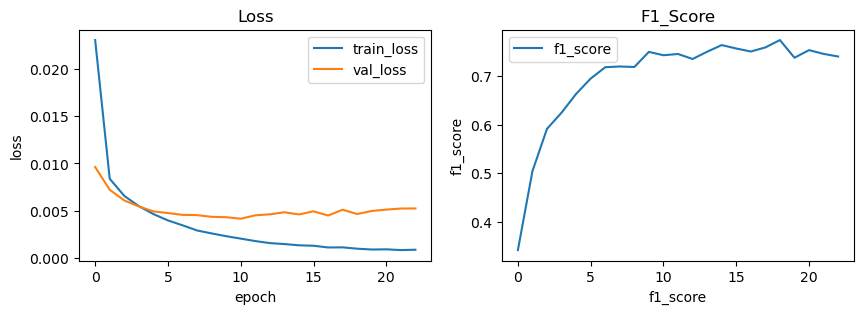

In [24]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(range(len(history['train_loss'])),history['train_loss'], label='train_loss')
plt.plot(range(len(history['train_loss'])),history['val_loss'], label='val_loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(history['f1_score'])), history['f1_score'], label='f1_score')
plt.title('F1_Score')
plt.ylabel('f1_score')
plt.xlabel('f1_score')
plt.legend()

plt.show()